In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset Creation

In [3]:
import zipfile

with zipfile.ZipFile("/kaggle/input/tgs-salt-identification-challenge/train.zip","r") as z:
    z.extractall("/kaggle/working/train/")

In [4]:
with zipfile.ZipFile("/kaggle/input/tgs-salt-identification-challenge/test.zip","r") as z:
    z.extractall("/kaggle/working/test/")

In [6]:
import os

def get_unique_ids(directory):
    unique_ids = set()
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            # Extract ID from filename
            im_id = filename.split(".")[0]
            unique_ids.add(im_id)
    return list(unique_ids)

directory = "/kaggle/working/train/images"
unique_images_ids = get_unique_ids(directory)

directory = "/kaggle/working/train/masks"
unique_masks_ids = get_unique_ids(directory)

print(len(unique_images_ids))
print(unique_images_ids == unique_masks_ids)

4000
True


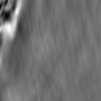

In [7]:
import random
from PIL import Image

#Visualize an Image to see the kind of data we are dealing with

element = random.choice(unique_images_ids) + ".png"

im = Image.open("/kaggle/working/train/images/" + element)
im

(101, 101, 3)
255


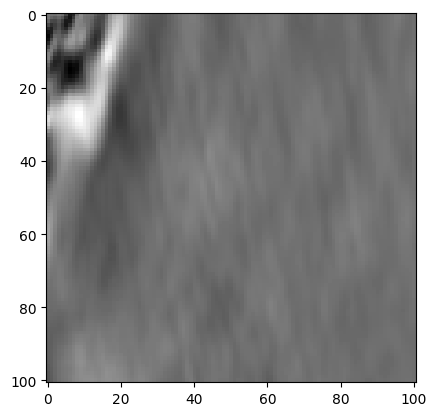

In [8]:
image = np.array(im)
print(image.shape)
print(image.max())
plt.imshow(image)

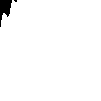

In [9]:
mask = Image.open("/kaggle/working/train/masks/" + element)
mask

(101, 101)
255


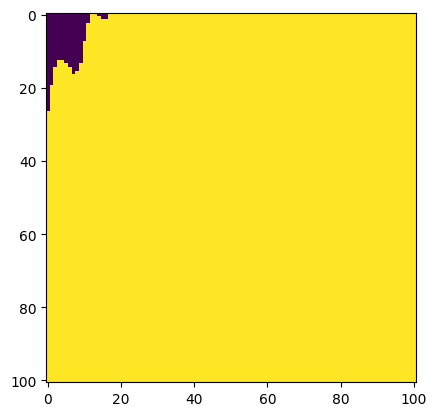

In [10]:
ms = np.array(mask.convert("L"))
print(ms.shape)
print(ms.max())
plt.imshow(ms)


In [11]:
import random

def select_random_ids(unique_ids, percentage):
    num_ids_to_select = int(len(unique_ids) * (percentage))
    selected_ids = unique_ids[:num_ids_to_select]
    return selected_ids

In [12]:
def filter_picture_names(picture_names, selected_ids, train=True):
    filtered_names = []
    for picture_name in picture_names:
        # Extract ID from picture name
        im_id = picture_name.split(".")[0]
        # Check if ID is in the selected IDs list
        if train:
            if im_id in selected_ids:
                filtered_names.append(picture_name)
        else:
            if im_id not in selected_ids:
                filtered_names.append(picture_name)
    return filtered_names

In [13]:
def split_data(image_dir, train_val_split= 0.8, train=True):
    unique_ids = get_unique_ids(image_dir)
    selected_ids = select_random_ids(unique_ids,train_val_split)
    filtered_names = filter_picture_names(os.listdir(image_dir), selected_ids, train)
    
    return filtered_names

In [48]:
from torch.utils.data import Dataset
import pathlib
from typing import Tuple
from PIL import Image
import os


class TGSSaltDataset(Dataset):
    
    def __init__(self, image_dir, mask_dir, train_val_split=0.8, train=True, transform=None) -> None:
        
        #Create class attributes
        # Setup transforms
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = split_data(image_dir,train_val_split,train)

    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index]) #Correct the name for mask files
        
        image = np.array(Image.open(img_path)) #Coloured Images
        #image = torch.Tensor(image).permute(2,0,1).numpy()
        mask = np.array(Image.open(mask_path), dtype = np.float32) #Gray Scale
        mask[mask == mask.max()] = 1.0 #Replace true label by 1 in order to work with sigmoid
        #mask = torch.Tensor(mask).unsqueeze(2).numpy()
        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask= mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        
        
        return image, mask # return data, label

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

#Resizing to 128 to work with U-Net
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            #A.PadIfNeeded(min_height=128, min_width=128, border_mode=cv2.BORDER_CONSTANT, value=0),  # padding with zeros
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        #A.PadIfNeeded(min_height=128, min_width=128, border_mode=cv2.BORDER_CONSTANT, value=0),  # padding with zeros
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [49]:
train_dataset = TGSSaltDataset("/kaggle/working/train/images","/kaggle/working/train/masks",0.8,True, transform = train_transform)

torch.Size([128, 128])


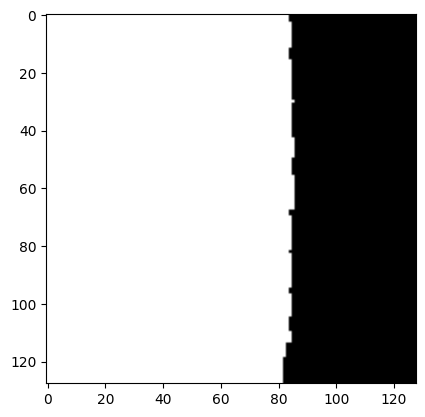

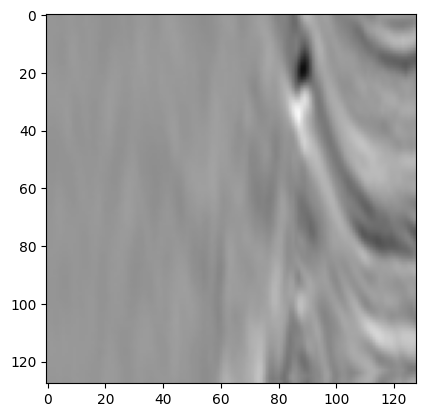

In [50]:
img,mask = train_dataset[12]
plt.imshow(mask, cmap= 'gray')
plt.figure()
plt.imshow(img.permute(1,2,0))
#img
print(mask.shape)

In [52]:
val_dataset = TGSSaltDataset("/kaggle/working/train/images","/kaggle/working/train/masks",0.8,False, transform= val_transform)

torch.Size([128, 128])


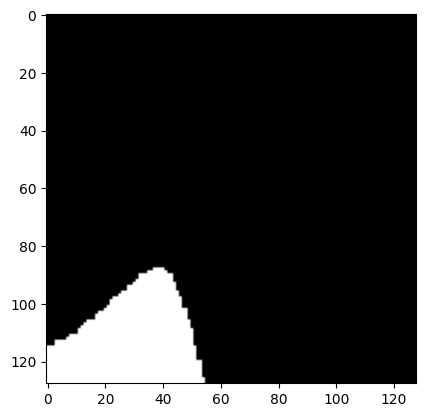

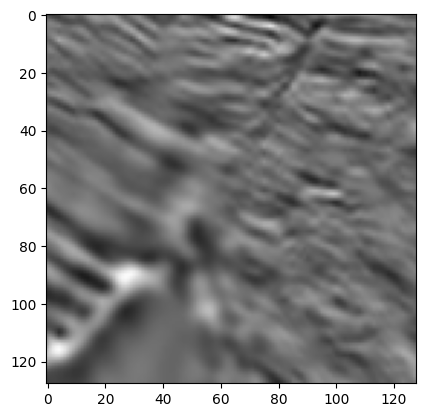

In [53]:
img,mask = val_dataset[1]
plt.imshow(mask, cmap= 'gray')
plt.figure()
plt.imshow(img.permute(1,2,0))
#img
print(mask.shape)

In [55]:
print(len(train_dataset))
print(len(val_dataset))

3200
800


Datasets correctly implementes with augmentations and partitioning

In [56]:
#Create Dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_dataset, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

torch.Size([64, 3, 128, 128])
torch.Size([64, 128, 128])


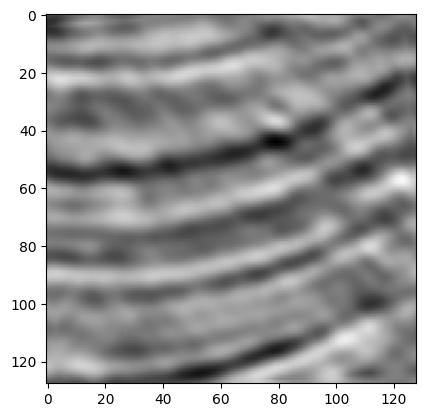

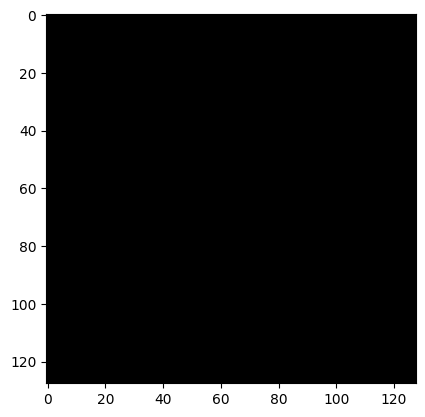

In [57]:
for idx, (X,y) in enumerate(train_dataloader):
    print(X.shape)
    print(y.shape)
    plt.imshow(X[0].permute(1,2,0), cmap= 'gray')
    
    plt.figure()
    plt.imshow(y[0].unsqueeze(0).permute(1,2,0), cmap= 'gray')

    break

# Model Creation - UNet Implementation

In [28]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

In [29]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [30]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [31]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        #Implementation of skip connections
        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [32]:
#Create random test image
test = torch.randn(1,3,128,128)
test.shape

torch.Size([1, 3, 128, 128])

In [33]:
#Check if output shape is correct
model = UNet(3,10)
x = model(test)
x.shape

torch.Size([1, 10, 128, 128])

Test model with random image from dataset to check problems with dimensions etc

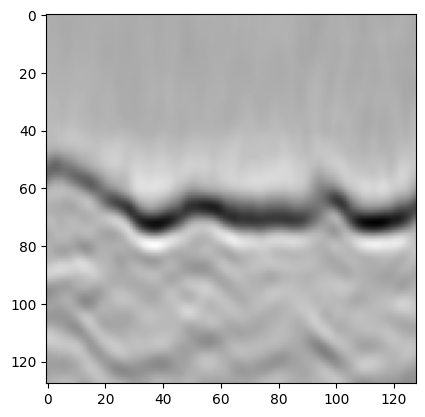

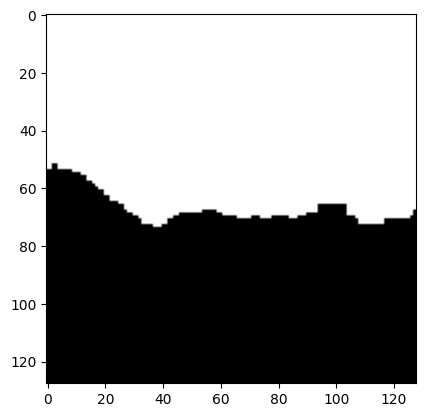

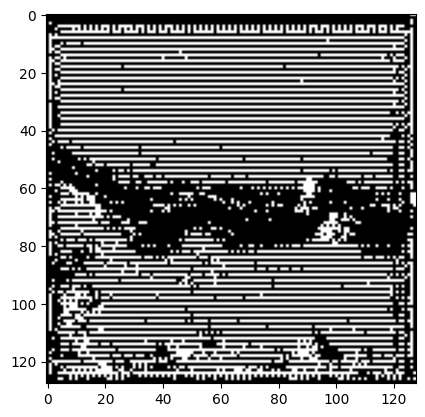

In [83]:
model_untrained = UNet(3,1).to(device)

random_batch_index = 3
for i, batch in enumerate(val_dataloader):
    if i == random_batch_index:
        X, y = batch
        break

#batch,(X,y) = next(enumerate(val_dataloader))
X = X.to(device)
y = y.float().unsqueeze(1).to(device, dtype = torch.float)

preds_untrained = model_untrained(X)

preds_untrained = torch.sigmoid(preds_untrained)
preds_untrained = (preds_untrained > 0.5).float()


plt.imshow(X[0].squeeze(0).permute(1,2,0).cpu(), cmap= 'gray')
    
plt.figure()
plt.imshow(y[0].permute(1,2,0).cpu(), cmap= 'gray')

plt.figure()
plt.imshow(preds_untrained[0].permute(1,2,0).cpu().detach().numpy(), cmap= 'gray')

Evaluation metric implementation:

- For each input check
        - Is the mask empty? --> If yes, check if you predicted anything --> If yes, score = 0, if no, score = 1
        - If mask not empty, check if predicted anything --> if no, score = 0, if yes, proceed with calculations of IOU

In [141]:
def IoU(img: torch.Tensor, mask: torch.Tensor) -> int:
    
    intersection = (img * mask).sum()
    union = (img + mask - (img*mask)).sum()
    iou = intersection/union
    
    return iou

In [82]:
def accuracy_IoU(img: torch.Tensor, mask: torch.Tensor) -> int:
    
    accuracy_score = 0
    threshold = np.arange(0.5, 1.0, 0.05) #Array of thresholds from 0.5 to 0.95 with step 0.05
    accuracy_list = []
    iou = IoU(img, mask)
    
    if torch.all(mask == 0): #If mask is empty
        
        if torch.all(img == 0):
            accuracy_score = 1 #Perect score if mask is empty and we predict nothing
        else:
            accuracy_score = 0 #0 score if mask is empty and we predict something
            
    else: #If mask is not empty
        
        for t in threshold:
            if iou >= t:
                accuracy_list.append(1)
            else:
                accuracy_list.append(0)
                
        accuracy_score = np.array(accuracy_list).mean()
    
    return accuracy_score

In [95]:
def accuracy_IoU_batch(img: torch.Tensor, mask: torch.Tensor) -> int:
    
    accuracy_list = []
    
    for j in range(img.shape[0]):
        acc = accuracy_IoU(img[j].squeeze(),mask[j].squeeze())
        accuracy_list.append(acc)
        
    accuracy_score = np.array(accuracy_list).mean()
    
    return accuracy_score

In [142]:
iou = IoU(preds_untrained[1].squeeze(), y[1].squeeze())
iou

tensor(0.7712, device='cuda:0')

In [143]:
acc = accuracy_IoU_batch(preds_untrained, y)
acc

0.265625

# Training

In [145]:
LEARNING_RATE = 1e-4

model = UNet(in_channels=3, num_classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
accuracy_fn = accuracy_IoU_batch


In [100]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
              accuracy_fn) -> Tuple[float, float]:
    
    model.train()


    train_loss = 0
  
    train_accuracy = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X = X.to(device)
        y = y.float().unsqueeze(1).to(device, dtype = torch.float)

        # 1. Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        #loss_fn returns already the average loss in all the pixels of the batch
            
        #Applies sigmoid and 0.5 threshold to predictions
        preds = torch.sigmoid(y_pred)
        preds = (preds > 0.5).float()
        
      
        accuracy = accuracy_fn(preds,y)
        train_accuracy += accuracy
            
                
        # 2. Calculate  and accumulate loss
        train_loss += loss.item()
        
        #print(f"test_loss : {train_loss} | num_examples : {num_examples} | accuracy : {accuracy}")
        
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        
        

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)

    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

In [98]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
             accuracy_fn) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 



    # Setup test loss and test accuracy values
    test_loss = 0
    
 
    test_accuracy = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X = X.to(device)
            y = y.float().unsqueeze(1).to(device, dtype = torch.float)

            # 1. Forward pass
            test_pred_logits = model(X)
            
            #Calculates the Dice coefficient
            preds = torch.sigmoid(test_pred_logits)
            preds = (preds > 0.5).float()
            
            
            
            
            accuracy = accuracy_fn(preds,y)
            test_accuracy += accuracy


            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()


    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_accuracy = test_accuracy / len(dataloader)
    
    
    return test_loss,test_accuracy

In [144]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          accuracy_fn,
         save_freq = 0,
         save_name = 'Sample') -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
        "train_accuracy" : [],
        "test_loss": [],
        "test_accuracy" : []
    }

  # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model=model,
                              dataloader=train_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              device=device,
                               accuracy_fn=accuracy_fn)
        test_loss, test_accuracy = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device,
                                accuracy_fn= accuracy_fn)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.10f} | train_accuracy: {train_accuracy:.4f} |" 
          f"test_loss: {test_loss:.10f} | test_accuracy: {test_accuracy:.4f}"      
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)
        
        if (save_freq > 0) :
            if (epoch % save_freq == 0):
                print(f"Epoch: {epoch+1} | Saving model")
                torch.save(obj=model.state_dict(),f=("/kaggle/working/models/" + save_name +f"_Epoch_{epoch}.pth"))
            
        
    # Return the filled results at the end of the epochs
    return results

In [108]:
import os

os.makedirs("/kaggle/working/models", exist_ok=True)

In [146]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

EPOCHS = 151

results = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=val_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=EPOCHS,
            device=device,
            accuracy_fn=accuracy_fn,
            save_freq=5,
            save_name = "UNET_Segmentation")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/151 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6461970162 | train_accuracy: 0.2458 |test_loss: 0.7697642446 | test_accuracy: 0.2365
Epoch: 1 | Saving model
Epoch: 2 | train_loss: 0.5180403763 | train_accuracy: 0.4932 |test_loss: 0.4761718030 | test_accuracy: 0.5435
Epoch: 3 | train_loss: 0.4819359058 | train_accuracy: 0.5040 |test_loss: 0.4616212386 | test_accuracy: 0.4980
Epoch: 4 | train_loss: 0.4290241235 | train_accuracy: 0.5512 |test_loss: 0.4203411249 | test_accuracy: 0.6093
Epoch: 5 | train_loss: 0.4166190714 | train_accuracy: 0.5715 |test_loss: 0.3793268548 | test_accuracy: 0.6492
Epoch: 6 | train_loss: 0.3892321682 | train_accuracy: 0.5943 |test_loss: 0.3779306137 | test_accuracy: 0.5828
Epoch: 6 | Saving model
Epoch: 7 | train_loss: 0.3825069225 | train_accuracy: 0.6120 |test_loss: 0.4884963884 | test_accuracy: 0.4252
Epoch: 8 | train_loss: 0.3674544907 | train_accuracy: 0.6230 |test_loss: 0.3540063317 | test_accuracy: 0.6673
Epoch: 9 | train_loss: 0.3598506176 | train_accuracy: 0.6328 |test_loss:

There seems to be overfitting from the epoch 25 onwards, as the training loss continued to decrease, while the testing loss stagnated.

A possible solution is to apply more radical data augmentation techniques.

# Comparison trained and untrained models

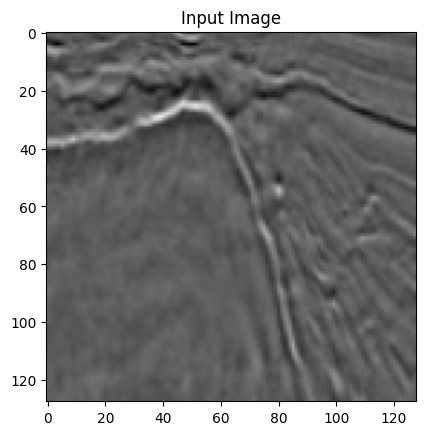

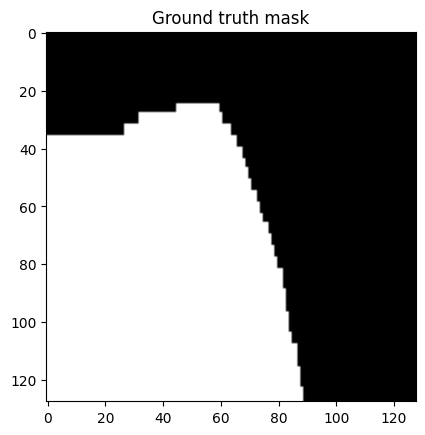

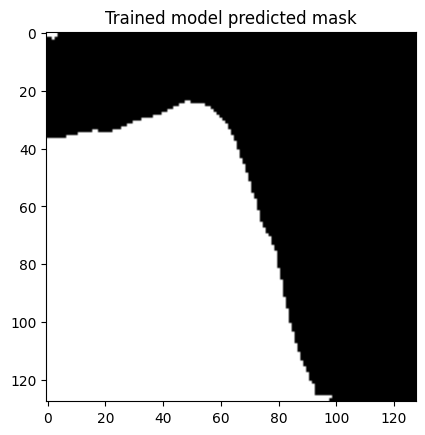

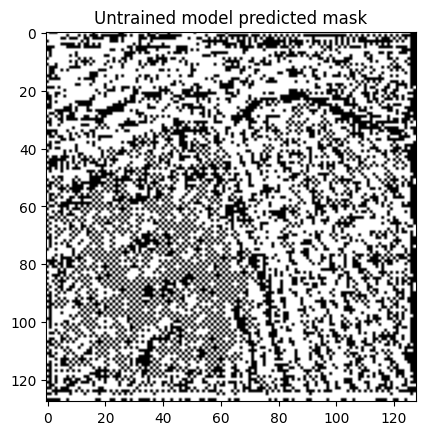

In [147]:
model_untrained = UNet(3,1).to(device)

random_batch_index = 10
for i, batch in enumerate(val_dataloader):
    if i == random_batch_index:
        X, y = batch
        break
        
img_idx = 9

X = X.to(device)
y = y.float().unsqueeze(1).to(device, dtype = torch.float)

preds = model(X)
preds_untrained = model_untrained(X)

preds = torch.sigmoid(preds)
preds = (preds > 0.5).float()

preds_untrained = torch.sigmoid(preds_untrained)
preds_untrained = (preds_untrained > 0.5).float()

plt.figure()
plt.title("Input Image")
plt.imshow(X[img_idx].squeeze(0).permute(1,2,0).cpu(), cmap= 'gray')
    
plt.figure()
plt.title("Ground truth mask")
plt.imshow(y[img_idx].permute(1,2,0).cpu(), cmap= 'gray')

plt.figure()
plt.title("Trained model predicted mask")
plt.imshow(preds[img_idx].permute(1,2,0).cpu().detach().numpy(), cmap= 'gray')

plt.figure()
plt.title("Untrained model predicted mask")
plt.imshow(preds_untrained[img_idx].permute(1,2,0).cpu().detach().numpy(), cmap= 'gray')

The valuation metric punishes very severely small errors when the mask is empty -> If only one pixel is predicted, the accuracy is put entirely to 0

From my analysis of the predictions compared to the ground truths, the model seems to have learned to identify the regions with salt deposits reasonably well. It can improve the localization.

In [151]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

#Resizing to 128 to work with U-Net
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

train_transform_2 = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            #A.PadIfNeeded(min_height=128, min_width=128, border_mode=cv2.BORDER_CONSTANT, value=0),  # padding with zeros
            #A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.1625, scale_limit=0.6, rotate_limit=0, p=0.7),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [152]:
train_dataset_2 = TGSSaltDataset("/kaggle/working/train/images","/kaggle/working/train/masks",0.8,True, transform = train_transform_2)

BATCH_SIZE = 64

train_dataloader_2 = DataLoader(dataset=train_dataset_2, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?


In [154]:
LEARNING_RATE = 1e-4

#model_name_to_load = "/kaggle/working/models/UNET_Segmentation_Epoch_25.pth"

model_2 = UNet(in_channels=3, num_classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=LEARNING_RATE)
accuracy_fn = accuracy_IoU_batch

#model_2.load_state_dict(torch.load(f=model_name_to_load))

In [155]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

EPOCHS = 50

results_2 = train(model=model_2,
            train_dataloader=train_dataloader_2,
            test_dataloader=val_dataloader,
            optimizer=optimizer_2,
            loss_fn=loss_fn,
            epochs=EPOCHS,
            device=device,
            accuracy_fn=accuracy_fn,
            save_freq=5,
            save_name = "UNET_Segmentation_Round2")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6574335742 | train_accuracy: 0.2602 |test_loss: 0.6582700106 | test_accuracy: 0.3678
Epoch: 1 | Saving model
Epoch: 2 | train_loss: 0.5651543987 | train_accuracy: 0.4487 |test_loss: 0.4906369700 | test_accuracy: 0.5385
Epoch: 3 | train_loss: 0.5134114188 | train_accuracy: 0.4917 |test_loss: 0.4503264290 | test_accuracy: 0.5537
Epoch: 4 | train_loss: 0.4826790231 | train_accuracy: 0.5150 |test_loss: 0.5749396590 | test_accuracy: 0.4161
Epoch: 5 | train_loss: 0.4618784618 | train_accuracy: 0.5385 |test_loss: 0.4476878735 | test_accuracy: 0.5345
Epoch: 6 | train_loss: 0.4427423805 | train_accuracy: 0.5633 |test_loss: 0.4266735430 | test_accuracy: 0.5415
Epoch: 6 | Saving model
Epoch: 7 | train_loss: 0.4164171976 | train_accuracy: 0.5833 |test_loss: 0.3716603013 | test_accuracy: 0.6149
Epoch: 8 | train_loss: 0.4138627076 | train_accuracy: 0.5846 |test_loss: 0.4244363262 | test_accuracy: 0.5553
Epoch: 9 | train_loss: 0.4090326619 | train_accuracy: 0.5916 |test_loss:

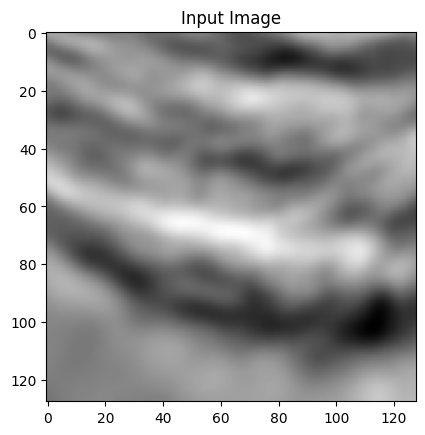

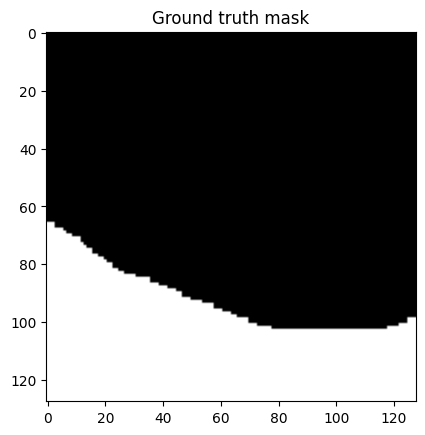

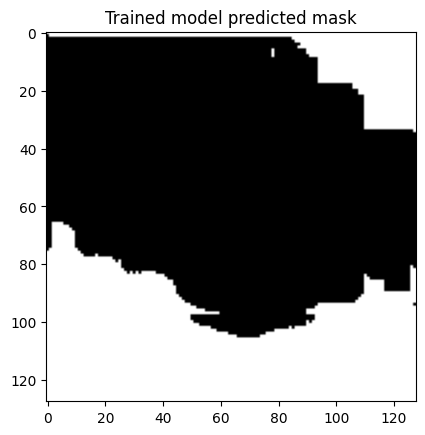

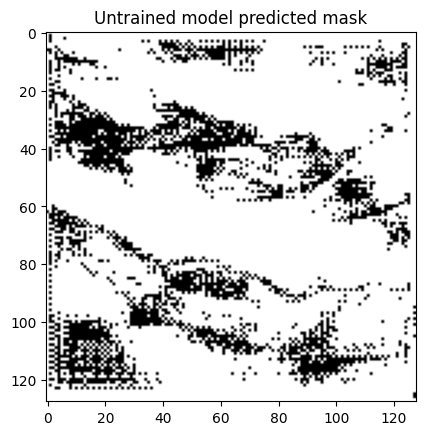

In [140]:
model_untrained = UNet(3,1).to(device)

random_batch_index = 10
for i, batch in enumerate(val_dataloader):
    if i == random_batch_index:
        X, y = batch
        break
        
img_idx = 33

X = X.to(device)
y = y.float().unsqueeze(1).to(device, dtype = torch.float)

preds = model_2(X)
preds_untrained = model_untrained(X)

preds = torch.sigmoid(preds)
preds = (preds > 0.5).float()

preds_untrained = torch.sigmoid(preds_untrained)
preds_untrained = (preds_untrained > 0.5).float()

plt.figure()
plt.title("Input Image")
plt.imshow(X[img_idx].squeeze(0).permute(1,2,0).cpu(), cmap= 'gray')
    
plt.figure()
plt.title("Ground truth mask")
plt.imshow(y[img_idx].permute(1,2,0).cpu(), cmap= 'gray')

plt.figure()
plt.title("Trained model predicted mask")
plt.imshow(preds[img_idx].permute(1,2,0).cpu().detach().numpy(), cmap= 'gray')

plt.figure()
plt.title("Untrained model predicted mask")
plt.imshow(preds_untrained[img_idx].permute(1,2,0).cpu().detach().numpy(), cmap= 'gray')

Things to do:
- How to consider the depth information for the prediction? 
- Try a different model, maybe with a ResNet50 as encoder in an UNET